In [1]:
import time
import os
import copy
import argparse
import pdb
import collections
import sys

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision

import pydicom
import skimage.io
import skimage.transform
import skimage.color
import skimage
import cv2
from PIL import Image

import model
from anchors import Anchors
import losses
from dataloader import CocoDataset, CSVDataset, MyDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer
from torch.utils.data import Dataset, DataLoader

import coco_eval
import csv_eval

assert torch.__version__.split('.')[1] == '4'

print('CUDA available: {}'.format(torch.cuda.is_available()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#参数
NAME="RSNA"
DATA_PATH = "/data/krf/dataset"
CSV_TRAIN = DATA_PATH + "/csv_train.csv"
CSV_VAL = DATA_PATH + "/csv_val.csv"
CSV_CLASSES = DATA_PATH + "/classes.csv"
TEST_PATH = DATA_PATH +"/stage_2_test_images"
DEPTH = 50
EPOCHS = 10

VAL_SIZE = 10
TRAIN_SIZE = 50

CUDA available: True


In [2]:
#数据预处理
import csv
import random
with open(DATA_PATH+"/stage_2_train_labels.csv") as f:
    reader = csv.reader(f)
    rows=[row for row in  reader]
    rows = rows[1:TRAIN_SIZE]
    random.shuffle(rows)
    for row in rows:
        row[0] = DATA_PATH+"/stage_2_train_images/"+row[0]+".dcm"
        if row[1] == '' and row[2] == '' and row[3] == '' and row[4] == '':
            row[5] = ''
        else:
            row[3] = str(float(row[1]) + float(row[3]))# x2 = x1 + w 
            row[4] = str(float(row[2]) + float(row[4]))# y2 = y1 + h
    val_rows = rows[:VAL_SIZE]
    train_rows = rows[VAL_SIZE:]
    print(len(val_rows),len(train_rows))
    with open(CSV_TRAIN,'w') as f2:
        write = csv.writer(f2)
        write.writerows(train_rows)
        print("csv_train 写入完毕")
    with open(CSV_VAL,'w') as f3:
        write = csv.writer(f3)
        write.writerows(val_rows)
        print("csv_val 写入完毕")

with open(CSV_CLASSES,'w') as f:
    write = csv.writer(f)
    row = ['1','0']
    write.writerow(row)
    print("csv_classes 写入完毕")

10 39
csv_train 写入完毕
csv_val 写入完毕
csv_classes 写入完毕


In [3]:
#%time
#制作数据loader
dataset_train = MyDataset(train_file=CSV_TRAIN, class_list=CSV_CLASSES, transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
dataset_val = MyDataset(train_file=CSV_VAL, class_list=CSV_CLASSES, transform=transforms.Compose([Normalizer(), Resizer()]))

#每次的sampler的参数：来源、batchsize、是否抛弃最后一层？？？
sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
# num_workers 同时工作的组？collater:校验用的吧
dataloader_train = DataLoader(dataset_train, num_workers=1, collate_fn=collater, batch_sampler=sampler)

# if dataset_val is not None:
#     sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
#     dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)

dataloader_val = DataLoader(dataset_val, num_workers=1, collate_fn=collater, batch_sampler=sampler_val)




In [4]:
# Create the model
if DEPTH == 18:
    retinanet = model.resnet18(num_classes=dataset_train.num_classes(), pretrained=True)
elif DEPTH == 34:
    retinanet = model.resnet34(num_classes=dataset_train.num_classes(), pretrained=True)
elif DEPTH == 50:
    retinanet = model.resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
elif DEPTH == 101:
    retinanet = model.resnet101(num_classes=dataset_train.num_classes(), pretrained=True)
elif DEPTH == 152:
    retinanet = model.resnet152(num_classes=dataset_train.num_classes(), pretrained=True)
else:
    raise ValueError('Unsupported model depth, must be one of 18, 34, 50, 101, 152')

use_gpu = True

if use_gpu:
    retinanet = retinanet.cuda()
#变成并行
retinanet = torch.nn.DataParallel(retinanet).cuda()
#训练模式
retinanet.training = True
#学习率0.00001  
optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
#如果3个epoch损失没有减少则降低学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
# TODO 这是干什么 deque是为了高效实现插入和删除操作的双向列表，适合用于队列和栈：这里是定义了一个500的队列
loss_hist = collections.deque(maxlen=500)

In [5]:
retinanet.train()
#BN层冻结！！
retinanet.module.freeze_bn()

print('Num training images: {}'.format(len(dataset_train)))

for epoch_num in range(EPOCHS):

    retinanet.train()
    retinanet.module.freeze_bn()
    
    epoch_loss = []
    
    for iter_num, data in enumerate(dataloader_train):
        try:
            optimizer.zero_grad()

            classification_loss, regression_loss = retinanet([Variable(data['img'].cuda().float()), Variable(data['annot'].cuda())])
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss
            
            if bool(loss == 0):
                continue
            #反向传播？
            loss.backward()

            #这是干嘛？？TODO
            torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

            #这?TODO
            optimizer.step()

            loss_hist.append(float(loss))

            epoch_loss.append(float(loss))

            print('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

            del classification_loss
            del regression_loss
        except Exception as e:
            print(e)
            continue


    print("Evaluating dataset")
#     retinanet.eval()
#     for index,data in enumerate(dataloader_val):
#         #data = dataset[index]
#         scale = data['scale']
#         # run network
#         #scores, labels, boxes = retinanet(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
#         print(Variable(data['img'].cuda()))
#         scores, labels, boxes = retinanet(Variable(data['img'].cuda()))
#         #mAP = csv_eval.evaluate(dataset_val,retinanet)
    mAP = csv_eval.evaluate(dataset_val,retinanet)
    #这一步也看不懂？？TODO 
    scheduler.step(np.mean(epoch_loss))
    
    torch.save(retinanet.module, 'weights/{}_retinanet_{}.pt'.format(NAME, epoch_num))
#     torch.save(retinanet.module, '{}_retinanet_{}.pt'.format(parser.dataset, epoch_num))

retinanet.eval()

torch.save(retinanet, 'weights/model_final.pt'.format(epoch_num))

Num training images: 33


/data/krf/anaconda/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch: 0 | Iteration: 3 | Classification loss: 0.56482 | Regression loss: 0.50520 | Running loss: 1.07002
Epoch: 0 | Iteration: 5 | Classification loss: 1.13002 | Regression loss: 1.04749 | Running loss: 1.62377
Epoch: 0 | Iteration: 6 | Classification loss: 1.10966 | Regression loss: 0.95433 | Running loss: 1.77051
Epoch: 0 | Iteration: 7 | Classification loss: 0.55578 | Regression loss: 0.57191 | Running loss: 1.60980
Epoch: 0 | Iteration: 8 | Classification loss: 0.54173 | Regression loss: 0.59898 | Running loss: 1.51599
Epoch: 0 | Iteration: 9 | Classification loss: 0.53452 | Regression loss: 0.54088 | Running loss: 1.44256
Epoch: 0 | Iteration: 11 | Classification loss: 0.51360 | Regression loss: 0.54176 | Running loss: 1.38724
Epoch: 0 | Iteration: 12 | Classification loss: 0.48279 | Regression loss: 0.61190 | Running loss: 1.35067
Epoch: 0 | Iteration: 14 | Classification loss: 0.45462 | Regression loss: 0.53646 | Running loss: 1.31072
Epoch: 0 | Iteration: 16 | Classification l

Epoch: 7 | Iteration: 8 | Classification loss: 0.12627 | Regression loss: 0.37729 | Running loss: 0.88610
Epoch: 7 | Iteration: 10 | Classification loss: 0.14094 | Regression loss: 0.34793 | Running loss: 0.88087
Epoch: 7 | Iteration: 13 | Classification loss: 0.28328 | Regression loss: 0.79456 | Running loss: 0.88343
Epoch: 7 | Iteration: 14 | Classification loss: 0.07839 | Regression loss: 0.27997 | Running loss: 0.87670
Epoch: 7 | Iteration: 15 | Classification loss: 0.18154 | Regression loss: 0.40905 | Running loss: 0.87307
Epoch: 7 | Iteration: 16 | Classification loss: 0.14881 | Regression loss: 0.39160 | Running loss: 0.86892
Evaluating dataset
9/9
mAP:
1: 0.11175720955456342
Epoch: 8 | Iteration: 0 | Classification loss: 0.25008 | Regression loss: 0.76827 | Running loss: 0.87076
Epoch: 8 | Iteration: 1 | Classification loss: 0.06878 | Regression loss: 0.25614 | Running loss: 0.86410
Epoch: 8 | Iteration: 2 | Classification loss: 0.15115 | Regression loss: 0.31934 | Running loss

AttributeError: 'str' object has no attribute 'copy'

In [6]:
#######################################################KRF CREATED 2018/11/15###################################################
class TestDataset(Dataset):
    """Test dataset.类似于MyDataset，不过没有csv和label"""

    def __init__(self,test_fp, transform=None):
        """
        Args:
            test_fp (string):训练集的文件目录
            
        """
        self.test_fp = test_fp
        self.transform = transform
        self.image_names = os.listdir(self.test_fp)[:100] #只测试100张
        for i in range(len(self.image_names)):
            self.image_names[i] =  os.path.join(TEST_PATH,self.image_names[i])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        img = self.load_image(idx)
        sample = {'img': img,'name' : self.image_names[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def load_image(self, image_index):
#         img = skimage.io.imread(self.image_names[image_index])
        ds = pydicom.read_file(self.image_names[image_index])
        img = ds.pixel_array
        
        if len(img.shape) == 2:
            img = skimage.color.gray2rgb(img)

        return img.astype(np.float32)/255.0
    
    #####################################Modified by KRF######################
    def image_aspect_ratio(self, image_index):
        #image = Image.open(self.image_names[image_index])
        ds = pydicom.read_file(self.image_names[image_index])
        img_arr = ds.pixel_array
        image = Image.fromarray(img_arr).convert('RGB')
        return float(image.width) / float(image.height)
###################################################################################################################################

In [7]:
#覆盖另一个
class NormalizerTest(object):

    def __init__(self):
        self.mean = np.array([[[0.485, 0.456, 0.406]]])
        self.std = np.array([[[0.229, 0.224, 0.225]]])

    def __call__(self, sample):

        image, name = sample['img'], sample['name']

        return {'img':((image.astype(np.float32)-self.mean)/self.std), 'name': name}
class ResizerTest(object):
    """Convert ndarrays in sample to Tensors."""

    #def __call__(self, sample, min_side=608, max_side=1024):
    ###########################################KRF Modeified###########################################################
    def __call__(self, sample, min_side=512, max_side=1024):
        image, name = sample['img'], sample['name']

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
        rows, cols, cns = image.shape

        pad_w = 32 - rows%32
        pad_h = 32 - cols%32

        new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)

        #annots[:, :4] *= scale

        return {'img': torch.from_numpy(new_image), 'name': name, 'scale': scale}

dataset_test = TestDataset(TEST_PATH,transform=transforms.Compose([NormalizerTest(), ResizerTest()]))
print(len(dataset_test))

100


In [15]:
# def detect(dataset, retinanet, score_threshold=0.05, max_detections=100, save_path=None):
#     """ Get the detections from the retinanet using the generator.
#     The result is a list of lists such that the size is:
#         all_detections[num_images][num_classes] = detections[num_detections, 4 + num_classes]
#     # Arguments
#         dataset         : The generator used to run images through the retinanet.
#         retinanet           : The retinanet to run on the images.
#         score_threshold : The score confidence threshold to use.
#         max_detections  : The maximum number of detections to use per image.
#         save_path       : The path to save the images with visualized detections to.
#     # Returns
#         A list of lists containing the detections for each image in the generator.
#     """
#     all_detections = [[None for i in range(dataset.num_classes())] for j in range(len(dataset))]
    
#     retinanet.eval()
    
#     with torch.no_grad():

#         for index in range(len(dataset)):
        
#             data = dataset[index]
#             scale = data['scale']

#             # run network
#             scores, labels, boxes = retinanet(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
#             #scores, labels, boxes = retinanet(data['img'].cuda().float())
#             scores = scores.cpu().numpy()
#             labels = labels.cpu().numpy()
#             boxes  = boxes.cpu().numpy()

#             # correct boxes for image scale
#             boxes /= scale

#             # select indices which have a score above the threshold
#             indices = np.where(scores > score_threshold)[0]
#             if indices.shape[0] > 0:
#                 # select those scores
#                 scores = scores[indices]

#                 # find the order with which to sort the scores
#                 scores_sort = np.argsort(-scores)[:max_detections]

#                 # select detections
#                 image_boxes      = boxes[indices[scores_sort], :]
#                 image_scores     = scores[scores_sort]
#                 image_labels     = labels[indices[scores_sort]]
#                 image_detections = np.concatenate([image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)

#                 # copy detections to all_detections
#                 for label in range(dataset.num_classes()):
#                     all_detections[index][label] = image_detections[image_detections[:, -1] == label, :-1]
#             else:
#                 # copy detections to all_detections
#                 for label in range(dataset.num_classes()):
#                     all_detections[index][label] = np.zeros((0, 5))

#             print('{}/{}'.format(index + 1, len(dataset)), end='\r')

#     return all_detections

In [8]:
#retinanet.load_state_dict('weights/RSNA_retinanet_3.pt')
def collaterTest(data):

    imgs = [s['img'] for s in data]
    names = [s['name'] for s in data]
    scales = [s['scale'] for s in data]
        
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = len(imgs)

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        padded_imgs[i, :int(img.shape[0]), :int(img.shape[1]), :] = img

#    max_num_annots = max(annot.shape[0] for annot in annots)
    
#     if max_num_annots > 0:

#         annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

#         if max_num_annots > 0:
#             for idx, annot in enumerate(annots):
#                 #print(annot.shape)
#                 if annot.shape[0] > 0:
#                     annot_padded[idx, :annot.shape[0], :] = annot
#     else:
#         annot_padded = torch.ones((len(annots), 1, 5)) * -1


    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return {'img': padded_imgs, 'names': names, 'scale': scales}


sampler_test = AspectRatioBasedSampler(dataset_test, batch_size=1, drop_last=False)
dataloader_test = DataLoader(dataset_test, num_workers=1, collate_fn=collaterTest, batch_sampler=sampler_test)

retinanet = torch.load("weights/RSNA_retinanet_3.pt")

use_gpu = True

if use_gpu:
    retinanet = retinanet.cuda()

retinanet.eval()

unnormalize = UnNormalizer()

# def draw_caption(image, box, caption):

#     b = np.array(box).astype(int)
#     cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
#     cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)



In [20]:
filepath = "submission.csv"
with open(filepath, 'w') as file:
    file.write("patientId,PredictionString\n")
    for idx, data in enumerate(dataloader_test):
        patientId = os.path.splitext(os.path.basename(data['names'][0]))[0]
        print(patientId)
        file.write(patientId+",")
        with torch.no_grad():
            st = time.time()
            scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
            print('Elapsed time: {}'.format(time.time()-st))
            idxs = np.where(scores>0.5)
            img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

            img[img<0] = 0
            img[img>255] = 255

            img = np.transpose(img, (1, 2, 0))

#             img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

            outstr = ""#输出到csv中
            resize_factor = 2 #输入的是512，原图像是1024
            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]
                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = int(bbox[2])
                y2 = int(bbox[3])
                #label_name = dataset_val.labels[int(classification[idxs[0][j]])]
#                 draw_caption(img, (x1, y1, x2, y2), "1")

#                 cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
                #print(label_name)
                width = x2 - x1;
                height = y2 - y1
                outstr += ' '
                s = scores[idxs[0][j]].cpu().numpy()
                print(s)
                outstr += str(s)
                outstr += ' '
                bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                               width*resize_factor, height*resize_factor)
                outstr += bboxes_str
                plt.imshow(ds.pixel_array, cmap=plt.cm.bone);
                
#             cv2.imshow('img', img)
#             cv2.waitKey(0)
            file.write(outstr+"\n")
        

c15132d6-6486-407e-b07a-2077eae209ce
Elapsed time: 0.23003411293029785
2badcdd6-4733-47ae-bdfc-412bb853e9a1
Elapsed time: 0.2856779098510742
1cf2d50f-703a-4d2b-a2b2-9ccc4594c875
Elapsed time: 0.14617586135864258
2975a1ea-26b6-4aef-95e8-a2f914bcb087
Elapsed time: 0.17275691032409668
037f16ff-46b6-45bf-b737-74072c46fab7
Elapsed time: 0.12059855461120605
30b596fe-fdf8-404c-9d3c-11341fd91ee5
Elapsed time: 0.06270503997802734
281e02d7-5a23-4cd5-96c0-923faa21434e
Elapsed time: 0.133758544921875
0181dc21-34be-4d57-87d9-74d91afc2458
Elapsed time: 0.09157586097717285
2bd3afa7-414c-431f-ad98-0d1b03f175b8
Elapsed time: 0.0783078670501709
124d7c34-d9f3-4c96-b20d-467f9f291926
Elapsed time: 0.1262376308441162
0db01d52-c8d4-490d-bf26-611a5a7616f4
Elapsed time: 0.11808896064758301
11286989-850c-44c4-adac-50a7d762b77f
Elapsed time: 0.06890368461608887
266490ca-ce52-4f5b-92ff-082dae7967c0
Elapsed time: 0.19334006309509277
20f38c57-8a12-493d-90ab-4c6c7f0798ba
Elapsed time: 0.2293717861175537
237d16b3-0c0

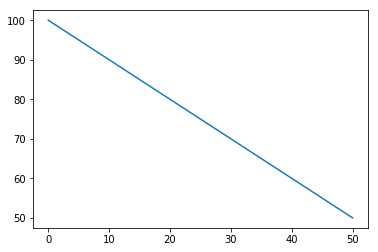